In [1]:
import numpy as np
import xarray as xr
import os
import fnmatch
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%config InlineBackend.figure_format = 'retina'

In [2]:
def preprocess(ds):
    ds = ds.expand_dims(dim={"source_id": [ds.source_id]})
    return ds

Load output of joint probability analysis:

In [5]:
#load wind speed & precipitation
ssps = ['ssp245','ssp585']

in_dirs = ['/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_1p5/sfcWind_pr/40yr_p98_lag0d_declus1d_ref2000/',
           '/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_1p5/sfcWind_pr/40yr_p99_lag0d_declus1d_ref2000/',
           '/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_1p5/sfcWind_pr/40yr_p98_lag2d_declus1d_ref2000/',
           '/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_1p5/sfcWind_pr/40yr_p98_lag0d_declus3d_ref2000/']

datasets = []
for in_dir in in_dirs:
    ds_fns = [] #get filenames wind & pr
    for top, dirs, files in os.walk(in_dir):
        for file in files:
               ds_fns.append(os.path.join(top, file))

    ds_surge_fns = [] #get filenames surge & pr
    for top, dirs, files in os.walk('/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_gesla2_tgs/surge_pr/40yr_p98_lag0d_declus1d_ref2000/'):
        for file in files:
               ds_surge_fns.append(os.path.join(top, file))          

    #we have more availability for sfcWind than surge (also needs psl), only open the overlapping files here
    ssps_ds = []
    for ssp in ssps:
        ssp_fns = fnmatch.filter(ds_fns,'*'+ssp+'*')
        ssp_surge_fns = fnmatch.filter(ds_surge_fns,'*'+ssp+'*')
        ssp_fns = [f for f in ssp_fns if '/'.join(f.split('/')[-2::]) in ['/'.join(k.split('/')[-2::]) for k in ssp_surge_fns]]
        ssp_ds = xr.open_mfdataset((ssp_fns),preprocess=preprocess,coords='minimal').chunk({'member_id':200})
        ssps_ds.append(ssp_ds)
    
    numex_ds = xr.concat(ssps_ds,dim='ssp')
    numex_ds = numex_ds.assign_coords({'ssp':ssps})

    num_joint_wp = numex_ds.num_joint_extremes.load()
    num_joint_wp_isect = num_joint_wp.where(np.isfinite(num_joint_wp).all(dim=['ssp','latitude','longitude']),drop=True) #members with both SSPs available
    datasets.append(num_joint_wp_isect)

num_joint_wps = xr.concat(datasets,dim='met')
num_joint_wps['met'] = ['default','p99','lag2d','declus3d']


In [6]:
in_dirs = ['/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_gesla2_tgs/surge_pr/40yr_p98_lag0d_declus1d_ref2000/',
           '/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_gesla2_tgs/surge_pr/40yr_p99_lag0d_declus1d_ref2000/',
           '/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_gesla2_tgs/surge_pr/40yr_p98_lag2d_declus1d_ref2000/',
           '/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_gesla2_tgs/surge_pr/40yr_p98_lag0d_declus3d_ref2000/']

datasets = []
for in_dir in in_dirs:
    ds_fns = []
    for top, dirs, files in os.walk(in_dir):
        for file in files:
            ds_fns.append(os.path.join(top, file))

    ssps_ds = []
    for ssp in ssps:
        ssp_fns = fnmatch.filter(ds_fns,'*'+ssp+'*')
        ssp_ds = xr.open_mfdataset((ssp_fns),preprocess=preprocess,coords='minimal').chunk({'member_id':200})
        ssps_ds.append(ssp_ds)

    numex_ds = xr.concat(ssps_ds,dim='ssp')
    numex_ds = numex_ds.assign_coords({'ssp':['ssp245','ssp585']})
    
    num_joint_sp = numex_ds.num_joint_extremes.load()
    num_joint_sp_isect = num_joint_sp.where(np.isfinite(num_joint_sp).all(dim=['ssp','tg']),drop=True) #members with both SSPs available
    datasets.append(num_joint_sp_isect)
    
num_joint_sps = xr.concat(datasets,dim='met')
num_joint_sps['met'] = ['default','p99','lag2d','declus3d']

Plot sensitivity of ensemble mean dN wp to methods:

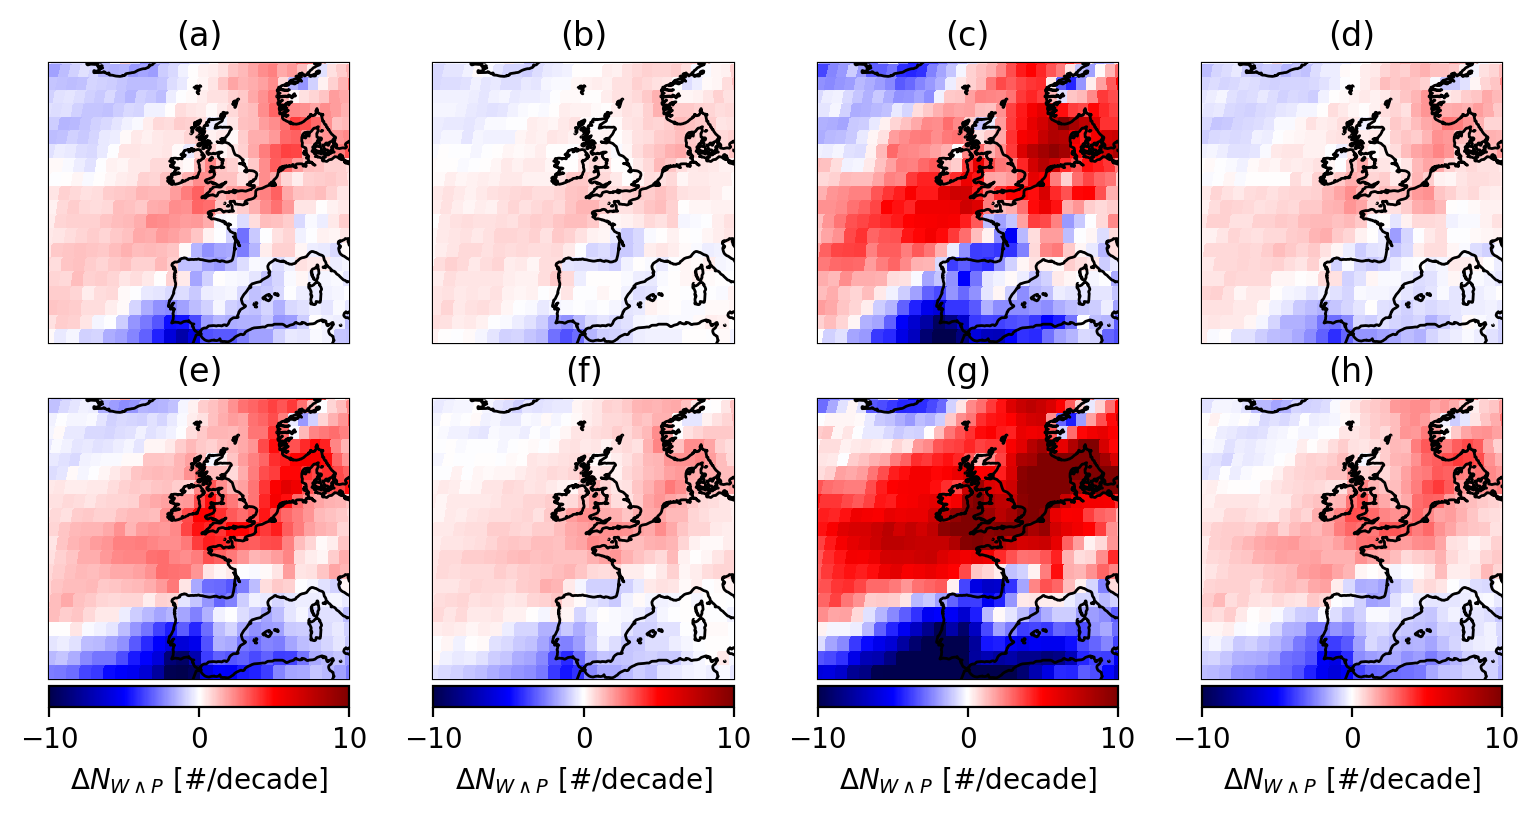

In [7]:
fig=plt.figure(figsize=(9.5,4)) #generate figure  
gs = fig.add_gridspec(2,4)

for s,ssp in enumerate(ssps):
    ssp_ds = num_joint_wps.sel(ssp=ssp).sum(dim='month',skipna=False)
                                   
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present
    
    for m,met in enumerate(num_joint_wps.met):
        ax = plt.subplot(gs[s,m],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
        #ax.add_feature(cartopy.feature.BORDERS, zorder=6, facecolor='black')
        #sc=(.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(cmap='Reds',vmin=0,vmax=30,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)

        sc=(.25*ssp_ds_diff.sel(met=met).mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
        #ratio = (100*ssp_ds_diff.sel(met=met)/ssp_ds_present.sel(met=met)).where(np.isfinite(ssp_ds_diff.sel(met=met)/ssp_ds_present.sel(met=met))).mean(dim='member_id',skipna=True).mean(dim='source_id',skipna=True)
        #sc=ratio.plot(cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
        
        #ax.text(-28, 61,'ERA5',transform=ccrs.PlateCarree(),fontweight='bold',size=12,ha='left',zorder=10)
        ax.coastlines(zorder=5)
        #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
        if s==1:
            cax=ax.inset_axes(bounds=(0, -.1,1,.075))
            cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta N_{W\wedge P}$ [#/decade]')
        ax.set_title(np.array([['(a)','(b)','(c)','(d)'],['(e)','(f)','(g)','(h)']])[s,m])

        sc.set_edgecolor('face')
#fig.savefig('Figures/ensmean_dN_WP_method_sensitivity.jpg',format='jpg',dpi=300,bbox_inches='tight')

Plot sensitivity of ensemble mean dN sp to methods:

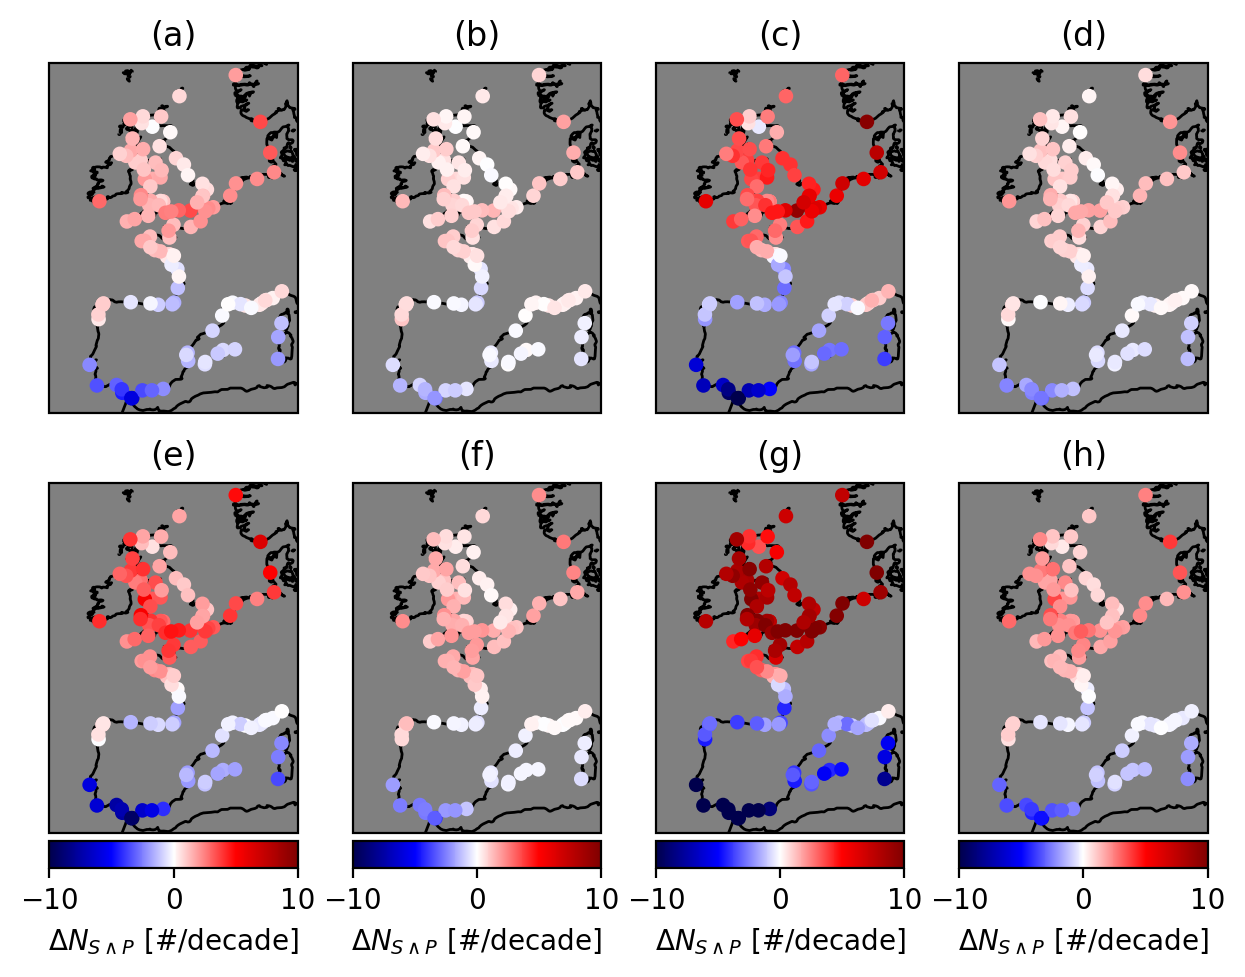

In [8]:
fig=plt.figure(figsize=(7.5,5)) #generate figure  
gs = fig.add_gridspec(2,4)

for s,ssp in enumerate(ssps):
    ssp_ds = num_joint_sps.sel(ssp=ssp).sum(dim='month',skipna=False)
                                   
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present
    
    for m,met in enumerate(num_joint_wps.met):
        ax = plt.subplot(gs[s,m],projection=ccrs.Robinson(central_longitude=0))
        
        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
        sc=ax.scatter(ssp_ds_diff.lon,ssp_ds_diff.lat,c=(.25*ssp_ds_diff.sel(met=met).mean(dim='member_id').mean(dim='source_id')),s=18,cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=4)

        ax.coastlines(zorder=1)
        ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())

        if s==1:
            cax=ax.inset_axes(bounds=(0, -.1,1,.075))
            cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta N_{S\wedge P}$ [#/decade]')
        ax.set_title(np.array([['(a)','(b)','(c)','(d)'],['(e)','(f)','(g)','(h)']])[s,m])

        sc.set_edgecolor('face')
#fig.savefig('Figures/ensmean_dN_SP_method_sensitivity.jpg',format='jpg',dpi=300,bbox_inches='tight')